In [4]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import json
import pickle
from pathlib import Path
from datetime import datetime

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import BallTree
from sklearn.cluster import KMeans

# Scipy for spatial operations
from math import radians, sin, cos, sqrt, atan2

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 50)
np.random.seed(42)

print("All libraries loaded!")

All libraries loaded!


In [5]:
RAW_DATA_PATH = "../data/satellite_images_19/data_with_image_paths.csv"  
IMAGE_DIR = "../data/satellite_images_19"
# Output paths
OUTPUT_DIR = "../data/processed/"
OUTPUTS_DIR = "outputs/spatial_eda"

# Random seed
RANDOM_STATE = 42

# Create output directories
for dir_path in [OUTPUT_DIR, OUTPUTS_DIR]:
    os.makedirs(dir_path, exist_ok=True)

In [6]:
# Load raw data
df = pd.read_csv(RAW_DATA_PATH)

print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nMissing values: {df.isnull().sum().sum()}")
print(f"\nTarget (price) statistics:")
print(df['price'].describe())

Shape: (16209, 22)

Columns: ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'image_path']

Missing values: 0

Target (price) statistics:
count    1.620900e+04
mean     5.374703e+05
std      3.603036e+05
min      7.500000e+04
25%      3.200000e+05
50%      4.500000e+05
75%      6.400000e+05
max      7.700000e+06
Name: price, dtype: float64


In [7]:
print(f"Unique locations: {df[['lat', 'long']].drop_duplicates().shape[0]:,}")
print(f"Latitude range: {df['lat'].min():.4f} to {df['lat'].max():.4f}")
print(f"Longitude range: {df['long'].min():.4f} to {df['long'].max():.4f}")
print(f"Price range: ${df['price'].min():,.0f} to ${df['price'].max():,.0f}")
print(f"Price skewness: {df['price'].skew():.2f}")

Unique locations: 15,750
Latitude range: 47.1593 to 47.7776
Longitude range: -122.5190 to -121.3150
Price range: $75,000 to $7,700,000
Price skewness: 4.03


---
##  Data Cleaning

In [8]:
print("="*60)
print("EXTREME VALUES CHECK")
print("="*60)

# Check for extreme values
print(f"Bedrooms > 10: {(df['bedrooms'] > 10).sum()}")
print(f"Bathrooms > 6: {(df['bathrooms'] > 6).sum()}")
print(f"Sqft > 10000: {(df['sqft_living'] > 10000).sum()}")
print(f"Price > $5M: {(df['price'] > 5000000).sum()}")
print(f"Price < $100K: {(df['price'] < 100000).sum()}")

EXTREME VALUES CHECK
Bedrooms > 10: 1
Bathrooms > 6: 5
Sqft > 10000: 2
Price > $5M: 4
Price < $100K: 19


In [9]:
df["image_path"] = df["image_path"].str.replace(
    "/cdc open project/satellite_images_19/",
    "/cdc open project/data/satellite_images_19/",
    regex=False
)

---
##  Base Feature Engineering

In [10]:
temp_df = df.copy()
temp_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,image_path
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,3,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240,/Users/vanshnarang/Desktop/cdc open project/da...
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,4,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605,/Users/vanshnarang/Desktop/cdc open project/da...
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,3,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455,/Users/vanshnarang/Desktop/cdc open project/da...
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,3,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750,/Users/vanshnarang/Desktop/cdc open project/da...
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,3,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071,/Users/vanshnarang/Desktop/cdc open project/da...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16204,5272200045,20141113T000000,378000,3,1.50,1000,6914,1.0,0,0,3,7,1000,0,1947,0,98125,47.7144,-122.319,1000,6947,/Users/vanshnarang/Desktop/cdc open project/da...
16205,9578500790,20141111T000000,399950,3,2.50,3087,5002,2.0,0,0,3,8,3087,0,2014,0,98023,47.2974,-122.349,2927,5183,/Users/vanshnarang/Desktop/cdc open project/da...
16206,7202350480,20140930T000000,575000,3,2.50,2120,4780,2.0,0,0,3,7,2120,0,2004,0,98053,47.6810,-122.032,1690,2650,/Users/vanshnarang/Desktop/cdc open project/da...
16207,1723049033,20140620T000000,245000,1,0.75,380,15000,1.0,0,0,3,5,380,0,1963,0,98168,47.4810,-122.323,1170,15000,/Users/vanshnarang/Desktop/cdc open project/da...


In [11]:
# Parse date if present
if 'date' in temp_df.columns:
    temp_df['date'] = pd.to_datetime(temp_df['date'])
    temp_df['sale_year'] = temp_df['date'].dt.year
    temp_df['sale_month'] = temp_df['date'].dt.month
    print("Date features extracted")

# Age features
current_year = 2015  # Using data's timeframe
temp_df['age'] = current_year - temp_df['yr_built']
temp_df['years_since_renovation'] = np.where(
    temp_df['yr_renovated'] > 0,
    current_year - temp_df['yr_renovated'],
    temp_df['age']
)
print("Age features created")

# Binary features
temp_df['has_basement'] = (temp_df['sqft_basement'] > 0).astype(int)
temp_df['has_view'] = (temp_df['view'] > 0).astype(int)
temp_df['was_renovated'] = (temp_df['yr_renovated'] > 0).astype(int)
print("Binary features created")

# Ratio features
temp_df['living_lot_ratio'] = temp_df['sqft_living'] / (temp_df['sqft_lot'] + 1)
temp_df['above_basement_ratio'] = temp_df['sqft_above'] / (temp_df['sqft_living'] + 1)
temp_df['sqft_per_bedroom'] = temp_df['sqft_living'] / (temp_df['bedrooms'] + 1)
temp_df['sqft_per_bathroom'] = temp_df['sqft_living'] / (temp_df['bathrooms'] + 0.5)
temp_df['total_rooms'] = temp_df['bedrooms'] + temp_df['bathrooms']
temp_df['sqft_per_room'] = temp_df['sqft_living'] / (temp_df['total_rooms'] + 1)
print("Ratio features created")

# Quality composite
temp_df['quality_score'] = temp_df['grade'] + temp_df['condition']
temp_df['luxury_index'] = (temp_df['grade'] >= 10).astype(int) + \
                     (temp_df['sqft_living'] >= 4000).astype(int) + \
                     temp_df['waterfront'] + \
                     (temp_df['view'] >= 3).astype(int)
print("Quality features created")

# Living space comparison with neighbors (15-suffix columns)
if 'sqft_living15' in temp_df.columns:
    temp_df['sqft_living_vs_neighbors'] = temp_df['sqft_living'] - temp_df['sqft_living15']
    temp_df['sqft_lot_vs_neighbors'] = temp_df['sqft_lot'] - temp_df['sqft_lot15']
    print("Neighbor comparison features created")

print(f"\nTotal features after base engineering: {len(temp_df.columns)}")

Date features extracted
Age features created
Binary features created
Ratio features created
Quality features created
Neighbor comparison features created

Total features after base engineering: 39


In [12]:
columns_to_drop = ['id', 'date','price','image_path', 'zipcode']

X = temp_df.drop(columns=columns_to_drop)
y = temp_df['price']

In [13]:
from sklearn.model_selection import train_test_split

y_log = np.log1p(y)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)

Train: (12967, 34)
Val: (3242, 34)


In [14]:
from xgboost import XGBRegressor

xgb_tabular = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb_tabular.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [15]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = np.expm1(xgb_tabular.predict(X_val))
y_true = np.expm1(y_val)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"Baseline XGBoost RMSE: {rmse:,.0f}")
print(f"Baseline XGBoost R²  : {r2:.4f}")

Baseline XGBoost RMSE: 114,260
Baseline XGBoost R²  : 0.8960


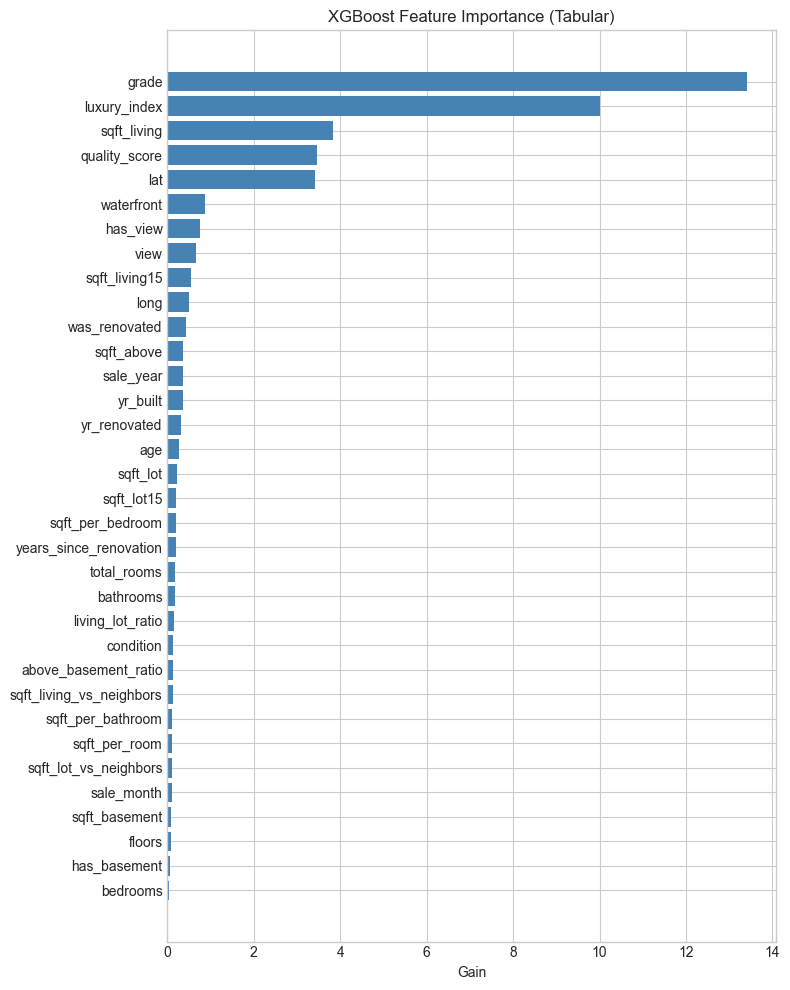

,feature,gain
8,grade,13.412485
31,luxury_index,10.008019
2,sqft_living,3.824638
30,quality_score,3.451730
13,lat,3.415105
5,waterfront,0.874580
22,has_view,0.750865
6,view,0.663021
15,sqft_living15,0.550410
14,long,0.489837


In [16]:
importances = xgb_tabular.get_booster().get_score(importance_type="gain")

imp_df = (
    pd.DataFrame(importances.items(), columns=["feature", "gain"])
    .sort_values("gain", ascending=True)
)

plt.figure(figsize=(8, 10))
plt.barh(imp_df["feature"], imp_df["gain"], color="steelblue")
plt.title("XGBoost Feature Importance (Tabular)")
plt.xlabel("Gain")
plt.tight_layout()
plt.show()

imp_df.sort_values("gain", ascending=False)

Correlation with Price:
price                       1.000000
sqft_living                 0.700933
grade                       0.664266
luxury_index                0.656402
quality_score               0.636747
sqft_per_bedroom            0.631078
sqft_above                  0.602648
sqft_living15               0.581781
sqft_per_room               0.569064
bathrooms                   0.525487
total_rooms                 0.463855
sqft_per_bathroom           0.423761
sqft_living_vs_neighbors    0.401853
view                        0.390534
has_view                    0.355841
sqft_basement               0.320301
lat                         0.310008
bedrooms                    0.304454
floors                      0.251428
waterfront                  0.245221
has_basement                0.182874
yr_renovated                0.133075
was_renovated               0.132729
living_lot_ratio            0.125219
sqft_lot                    0.088526
sqft_lot15                  0.076060
sqft_lot_vs_ne

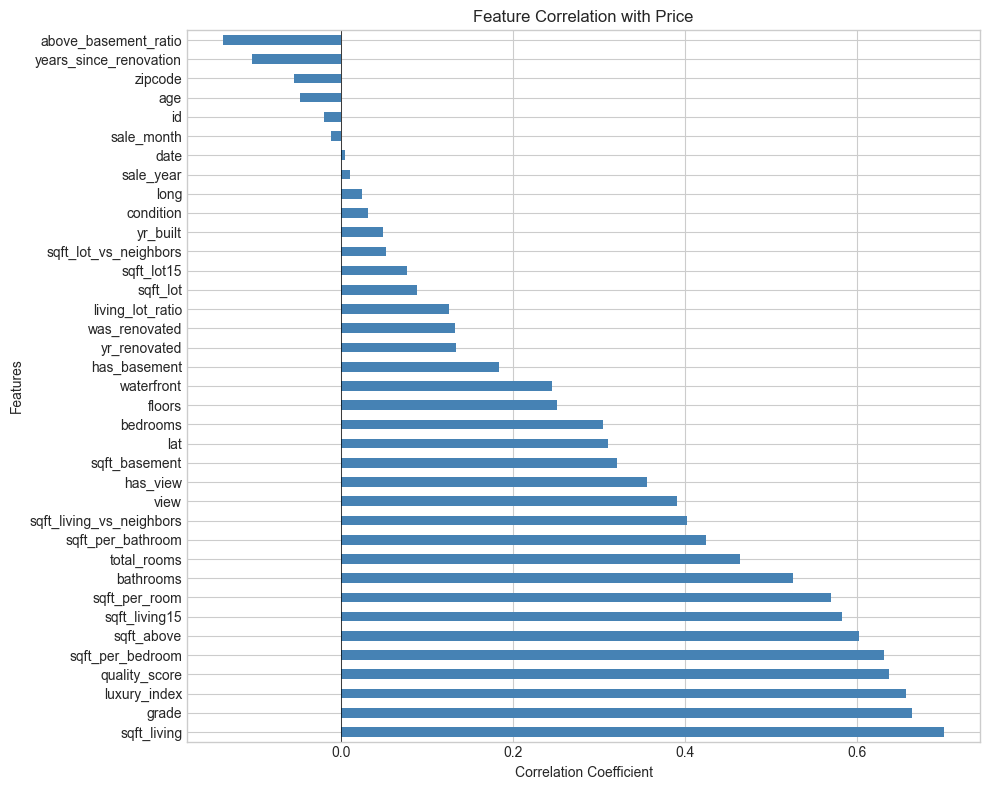


Strongly Correlated Features with Price (|r| > 0.3):
sqft_living                 0.700933
grade                       0.664266
luxury_index                0.656402
quality_score               0.636747
sqft_per_bedroom            0.631078
sqft_above                  0.602648
sqft_living15               0.581781
sqft_per_room               0.569064
bathrooms                   0.525487
total_rooms                 0.463855
sqft_per_bathroom           0.423761
sqft_living_vs_neighbors    0.401853
view                        0.390534
has_view                    0.355841
sqft_basement               0.320301
lat                         0.310008
bedrooms                    0.304454
Name: price, dtype: float64


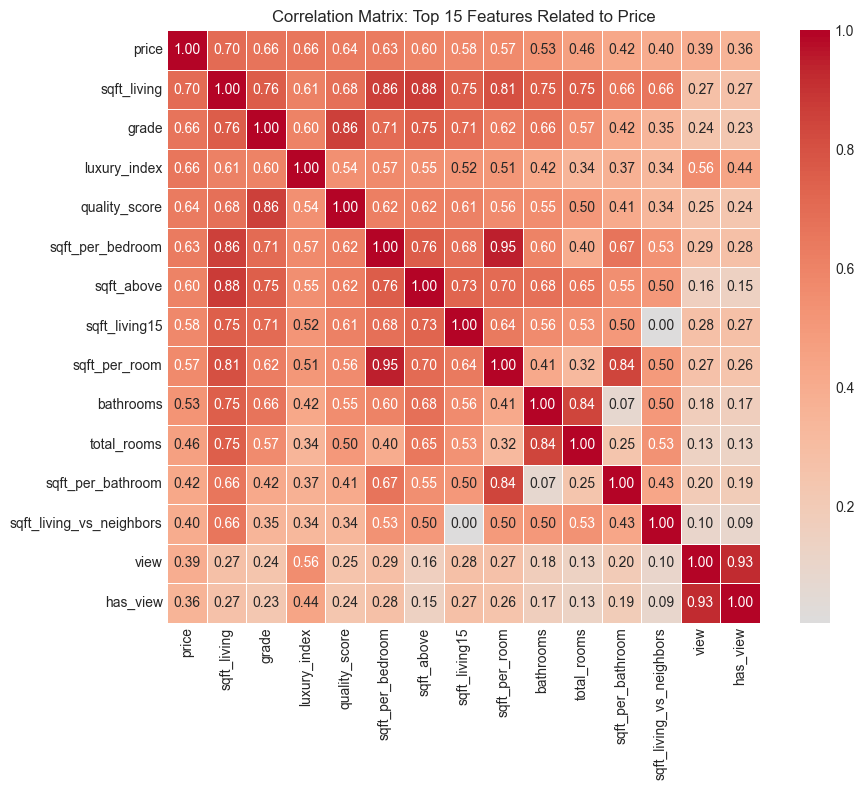

In [17]:
# Calculate correlation of all features with price
price_correlations = temp_df.drop(columns=['image_path']).corr()['price'].sort_values(ascending=False)

# Display correlations with price
print("Correlation with Price:")
print(price_correlations)

# Visualize correlations with price
plt.figure(figsize=(10, 8))
price_correlations.drop('price').plot(kind='barh', color='steelblue')
plt.title("Feature Correlation with Price")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

# Identify strongly correlated features (|correlation| > 0.3)
strong_correlations = price_correlations[abs(price_correlations) > 0.3].drop('price')
print("\nStrongly Correlated Features with Price (|r| > 0.3):")
print(strong_correlations)

# Optional: Create a more detailed heatmap showing top correlated features
top_n = 15  # Number of top correlated features to show
top_features = price_correlations.abs().sort_values(ascending=False).head(top_n).index.tolist()

plt.figure(figsize=(10, 8))
sns.heatmap(
    temp_df[top_features].corr(),
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5
)
plt.title(f"Correlation Matrix: Top {top_n} Features Related to Price")
plt.tight_layout()
plt.show()

---
## 6. Advanced Spatial Features Engineering 

### Key Geography:
- **Seattle Downtown** (47.6062, -122.3321) - Urban core
- **Bellevue Downtown** (47.6101, -122.2015) - Eastside premium
- **Microsoft Campus** (47.6423, -122.1391) - Tech hub
- **Waterfront areas** - Premium locations
- **North Seattle** - Generally higher prices

In [18]:
# ============================================================
# SPATIAL FEATURES - HELPER FUNCTIONS
# ============================================================

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees).
    Returns distance in kilometers.
    """
    R = 6371  # Earth's radius in kilometers
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    return R * c


# Key locations
KEY_LOCATIONS = {
    'downtown_seattle': (47.6062, -122.3321),
    'bellevue_downtown': (47.6101, -122.2015),
    'seattle_waterfront': (47.6064, -122.3420),
    'uw_campus': (47.6553, -122.3035),
    'seatac_airport': (47.4502, -122.3088),
    'microsoft_campus': (47.6423, -122.1391),
    'amazon_hq': (47.6225, -122.3361),
    'pike_place': (47.6097, -122.3422),
    'capitol_hill': (47.6253, -122.3222),
    'redmond_downtown': (47.6740, -122.1215),
}

print("Spatial helper functions defined")
print(f"{len(KEY_LOCATIONS)} key locations configured")

Spatial helper functions defined
10 key locations configured


In [19]:
class SpatialFeatureTransformer:
    """
    Computes spatial features in a leakage-safe manner.
    
    Fit on training data only, then transform any dataset.
    This ensures validation/test sets don't leak information.
    """
    
    def __init__(self, k_values=[5, 10, 20, 50], n_clusters=50):
        self.k_values = k_values
        self.n_clusters = n_clusters
        self.train_tree = None
        self.train_coords = None
        self.train_prices = None
        self.train_sqft = None
        self.train_grades = None
        self.zipcode_stats = None
        self.cluster_model = None
        self.cluster_stats = None
        self.is_fitted = False
        
    def fit(self, df):
        """
        Fit on training data only.
        """
        print("Fitting SpatialFeatureTransformer...")
        
        # Store training coordinates (convert to radians for BallTree)
        self.train_coords = np.radians(df[['lat', 'long']].values)
        self.train_prices = df['price'].values
        self.train_sqft = df['sqft_living'].values
        self.train_grades = df['grade'].values
        self.train_log_prices = np.log1p(df['price'].values)
        
        # Build BallTree from training data (haversine distance)
        self.train_tree = BallTree(self.train_coords, metric='haversine')
        print(f"BallTree built with {len(self.train_coords)} training points")
        
        # Compute zipcode statistics from training data
        self.zipcode_stats = df.groupby('zipcode').agg({
            'price': ['mean', 'median', 'std', 'count'],
            'sqft_living': 'mean',
            'grade': 'mean',
            'sqft_lot': 'mean',
        }).reset_index()
        self.zipcode_stats.columns = [
            'zipcode', 'zip_price_mean', 'zip_price_median', 
            'zip_price_std', 'zip_count', 'zip_sqft_mean', 
            'zip_grade_mean', 'zip_lot_mean'
        ]
        print(f"Zipcode statistics computed for {len(self.zipcode_stats)} zipcodes")
        
        # Fit spatial clustering on training data
        self.cluster_model = KMeans(
            n_clusters=self.n_clusters, 
            random_state=42, 
            n_init=10
        )
        train_clusters = self.cluster_model.fit_predict(df[['lat', 'long']].values)
        
        # Compute cluster statistics
        df_temp = df.copy()
        df_temp['spatial_cluster'] = train_clusters
        self.cluster_stats = df_temp.groupby('spatial_cluster').agg({
            'price': ['mean', 'median', 'std'],
            'grade': 'mean',
            'sqft_living': 'mean',
        }).reset_index()
        self.cluster_stats.columns = [
            'spatial_cluster', 'cluster_price_mean', 'cluster_price_median',
            'cluster_price_std', 'cluster_grade_mean', 'cluster_sqft_mean'
        ]
        print(f"Spatial clustering fitted with {self.n_clusters} clusters")
        
        self.is_fitted = True
        print("Fitting complete!")
        return self
    
    def transform(self, df, is_training=False):
        """
        Transform dataset using fitted training statistics.
        
        Args:
            df: DataFrame to transform
            is_training: If True, excludes self from KNN (avoids leakage)
        
        Returns:
            DataFrame with spatial features
        """
        if not self.is_fitted:
            raise ValueError("Transformer not fitted. Call fit() first.")
        
        print(f"Transforming {len(df)} samples (is_training={is_training})...")
        
        features = {}
        coords = np.radians(df[['lat', 'long']].values)
        
        # 1. KNN-BASED FEATURES
        for k in self.k_values:
            # Query k+1 neighbors if training (to exclude self)
            query_k = k + 1 if is_training else k
            distances, indices = self.train_tree.query(coords, k=query_k)
            
            if is_training:
                # Remove self (first neighbor is always self for training data)
                indices = indices[:, 1:]
                distances = distances[:, 1:]
            
            # Convert distances from radians to kilometers
            distances_km = distances * 6371
            
            # Get neighbor values
            neighbor_prices = self.train_prices[indices]
            neighbor_sqft = self.train_sqft[indices]
            neighbor_grades = self.train_grades[indices]
            neighbor_log_prices = self.train_log_prices[indices]
            
            # Price statistics
            features[f'knn_{k}_price_mean'] = np.mean(neighbor_prices, axis=1)
            features[f'knn_{k}_price_median'] = np.median(neighbor_prices, axis=1)
            features[f'knn_{k}_price_std'] = np.std(neighbor_prices, axis=1)
            features[f'knn_{k}_price_min'] = np.min(neighbor_prices, axis=1)
            features[f'knn_{k}_price_max'] = np.max(neighbor_prices, axis=1)
            
            # Log price statistics (more stable)
            features[f'knn_{k}_log_price_mean'] = np.mean(neighbor_log_prices, axis=1)
            
            # Distance features
            features[f'knn_{k}_avg_dist_km'] = np.mean(distances_km, axis=1)
            features[f'knn_{k}_max_dist_km'] = np.max(distances_km, axis=1)
            
            # Price per sqft from neighbors
            neighbor_price_per_sqft = neighbor_prices / (neighbor_sqft + 1)
            features[f'knn_{k}_price_per_sqft_mean'] = np.mean(neighbor_price_per_sqft, axis=1)
            
            # Grade comparison (how does this property compare to neighbors)
            features[f'knn_{k}_grade_diff'] = df['grade'].values - np.mean(neighbor_grades, axis=1)
            features[f'knn_{k}_grade_mean'] = np.mean(neighbor_grades, axis=1)
            
            # Sqft comparison
            features[f'knn_{k}_sqft_diff'] = df['sqft_living'].values - np.mean(neighbor_sqft, axis=1)
        
        print(f"KNN features computed for k={self.k_values}")
        
        # 2. DISTANCE TO KEY LOCATIONS
        for name, (lat, lon) in KEY_LOCATIONS.items():
            features[f'dist_to_{name}'] = df.apply(
                lambda row: haversine_distance(row['lat'], row['long'], lat, lon),
                axis=1
            ).values
        
        # Derived distance features
        features['dist_to_nearest_downtown'] = np.minimum(
            features['dist_to_downtown_seattle'],
            features['dist_to_bellevue_downtown']
        )
        features['dist_to_nearest_tech'] = np.minimum(
            features['dist_to_microsoft_campus'],
            features['dist_to_amazon_hq']
        )
        features['dist_to_water'] = features['dist_to_seattle_waterfront']
        
        print(f"Distance features computed for {len(KEY_LOCATIONS)} locations")
        
        # 3. ZIPCODE AGGREGATIONS
        zip_features = df[['zipcode']].merge(
            self.zipcode_stats, on='zipcode', how='left'
        )
        
        # Handle missing zipcodes (use overall training mean)
        for col in self.zipcode_stats.columns:
            if col != 'zipcode':
                zip_features[col] = zip_features[col].fillna(
                    self.zipcode_stats[col].mean()
                )
        
        # Add zipcode features
        for col in zip_features.columns:
            if col != 'zipcode':
                features[col] = zip_features[col].values
        
        # Relative features (compare property to its zipcode)
        features['price_vs_zip_ratio'] = df['sqft_living'].values * \
            (features['zip_price_mean'] / (features['zip_sqft_mean'] + 1))
        features['sqft_vs_zip_ratio'] = df['sqft_living'].values / (features['zip_sqft_mean'] + 1)
        features['grade_vs_zip_diff'] = df['grade'].values - features['zip_grade_mean']
        
        print(f"Zipcode features computed")
        
        # 4. SPATIAL CLUSTERING FEATURES
        cluster_assignments = self.cluster_model.predict(df[['lat', 'long']].values)
        
        cluster_features = pd.DataFrame({'spatial_cluster': cluster_assignments}).merge(
            self.cluster_stats, on='spatial_cluster', how='left'
        )
        
        for col in cluster_features.columns:
            if col != 'spatial_cluster':
                features[col] = cluster_features[col].values
        
        # Cluster relative features
        features['price_vs_cluster_ratio'] = df['sqft_living'].values * \
            (features['cluster_price_mean'] / (features['cluster_sqft_mean'] + 1))
        features['grade_vs_cluster_diff'] = df['grade'].values - features['cluster_grade_mean']
        
        print(f"Cluster features computed")
        
        # 5. ADDITIONAL GEOGRAPHIC FEATURES
        features['lat_zone'] = pd.cut(
            df['lat'], 
            bins=[47.0, 47.4, 47.6, 47.8, 48.0],
            labels=[0, 1, 2, 3]
        ).astype(float).values
        
        # Longitude zones (Seattle vs Eastside)
        features['long_zone'] = pd.cut(
            df['long'],
            bins=[-123.0, -122.3, -122.0, -121.0],
            labels=[0, 1, 2]  # 0=Seattle, 1=Eastside, 2=Far East
        ).astype(float).values
        
        # Distance from geographic center of data
        center_lat = df['lat'].mean()
        center_long = df['long'].mean()
        features['dist_from_center'] = df.apply(
            lambda row: haversine_distance(row['lat'], row['long'], center_lat, center_long),
            axis=1
        ).values

        print(f"Geographic zone features computed")

        # Create output DataFrame
        spatial_df = pd.DataFrame(features, index=df.index)
        
        print(f"Total spatial features: {len(spatial_df.columns)}")
        
        return spatial_df
    
    def fit_transform(self, df):
        """Fit and transform in one call (for training data)."""
        self.fit(df)
        return self.transform(df, is_training=True)
    
    def save(self, filepath):
        """Save fitted transformer to disk."""
        with open(filepath, 'wb') as f:
            pickle.dump(self, f)
        print(f"Transformer saved to {filepath}")
    
    @classmethod
    def load(cls, filepath):
        """Load fitted transformer from disk."""
        with open(filepath, 'rb') as f:
            return pickle.load(f)

---
## 7. Train/Val/Test Split (BEFORE Spatial Features)

In [20]:
train_df, val_df = train_test_split(
    df, 
    test_size=0.2,
    random_state=42
)

print(f"Training set:   {len(train_df):,} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set: {len(val_df):,} samples ({len(val_df)/len(df)*100:.1f}%)")


# Price distribution check
print(f"\nPrice distribution check:")
print(f"  Train mean:  ${train_df['price'].mean():,.0f}")
print(f"  Val mean:    ${val_df['price'].mean():,.0f}")

Training set:   12,967 samples (80.0%)
Validation set: 3,242 samples (20.0%)

Price distribution check:
  Train mean:  $536,804
  Val mean:    $540,135


---
## 8. Apply Spatial Features (Leakage-Safe)

In [21]:
# Spatial features config
KNN_K_VALUES = [5, 10, 20, 50] 
N_SPATIAL_CLUSTERS = 50 

spatial_transformer = SpatialFeatureTransformer(
    k_values=KNN_K_VALUES,
    n_clusters=N_SPATIAL_CLUSTERS
)

# Fit on training data
spatial_transformer.fit(train_df)

print("\nTransforming datasets...")


# Transform all splits
train_spatial = spatial_transformer.transform(train_df, is_training=True)
val_spatial = spatial_transformer.transform(val_df, is_training=False)

print(f"Spatial features shape: {train_spatial.shape[1]} features")

Fitting SpatialFeatureTransformer...
BallTree built with 12967 training points
Zipcode statistics computed for 70 zipcodes
Spatial clustering fitted with 50 clusters
Fitting complete!

Transforming datasets...
Transforming 12967 samples (is_training=True)...
KNN features computed for k=[5, 10, 20, 50]
Distance features computed for 10 locations
Zipcode features computed
Cluster features computed
Geographic zone features computed
Total spatial features: 81
Transforming 3242 samples (is_training=False)...
KNN features computed for k=[5, 10, 20, 50]
Distance features computed for 10 locations
Zipcode features computed
Cluster features computed
Geographic zone features computed
Total spatial features: 81
Spatial features shape: 81 features


In [44]:
spatial_transformer.save("outputs/spatial_eda/spatial_feature_transformer.pkl")

Transformer saved to outputs/spatial_eda/spatial_feature_transformer.pkl


In [22]:
# Merge spatial features with original data
print("Merging spatial features with original data")

train_df_full = pd.concat([train_df.reset_index(drop=True), train_spatial.reset_index(drop=True)], axis=1)
val_df_full = pd.concat([val_df.reset_index(drop=True), val_spatial.reset_index(drop=True)], axis=1)

print(f"Train full shape: {train_df_full.shape}")
print(f"Val full shape:   {val_df_full.shape}")

Merging spatial features with original data
Train full shape: (12967, 103)
Val full shape:   (3242, 103)


In [23]:
# Preview spatial features
print("\nSPATIAL FEATURES PREVIEW")
print("-"*40)
spatial_cols = train_spatial.columns.tolist()
print(f"Total spatial features: {len(spatial_cols)}")
print(f"\nFeature categories:")
print(f"  • KNN features: {len([c for c in spatial_cols if c.startswith('knn_')])}")
print(f"  • Distance features: {len([c for c in spatial_cols if c.startswith('dist_')])}")
print(f"  • Zipcode features: {len([c for c in spatial_cols if c.startswith('zip_')])}")
print(f"  • Cluster features: {len([c for c in spatial_cols if 'cluster' in c])}")
print(f"  • Other features: {len([c for c in spatial_cols if not any(x in c for x in ['knn_', 'dist_', 'zip_', 'cluster'])])}")


SPATIAL FEATURES PREVIEW
----------------------------------------
Total spatial features: 81

Feature categories:
  • KNN features: 48
  • Distance features: 14
  • Zipcode features: 7
  • Cluster features: 7
  • Other features: 2


---
## 9. Feature Analysis: Spatial Features Impact

In [24]:
print("="*60)
print("SPATIAL FEATURES CORRELATION WITH PRICE")
print("="*60)

# Calculate correlations for spatial features
spatial_corr = train_spatial.corrwith(train_df['price']).sort_values(ascending=False)

print("\nTop 15 Spatial Features by Correlation:")
print("-"*40)
for i, (feat, corr) in enumerate(spatial_corr.head(30).items()):
    print(f"{i+1:2d}. {feat:35s} {corr:.3f}")

print("\nBottom 5 Spatial Features:")
print("-"*40)
for feat, corr in spatial_corr.tail(5).items():
    print(f"    {feat:35s} {corr:.3f}")

SPATIAL FEATURES CORRELATION WITH PRICE

Top 15 Spatial Features by Correlation:
----------------------------------------
 1. price_vs_zip_ratio                  0.888
 2. price_vs_cluster_ratio              0.872
 3. knn_5_price_mean                    0.746
 4. knn_10_price_mean                   0.740
 5. knn_5_price_median                  0.735
 6. knn_20_price_mean                   0.734
 7. knn_10_price_median                 0.731
 8. knn_20_price_median                 0.721
 9. knn_50_price_mean                   0.712
10. knn_5_log_price_mean                0.709
11. knn_10_log_price_mean               0.704
12. knn_50_price_median                 0.703
13. knn_20_log_price_mean               0.695
14. knn_5_price_min                     0.677
15. knn_50_log_price_mean               0.674
16. knn_5_price_max                     0.673
17. knn_10_price_min                    0.661
18. knn_10_price_max                    0.649
19. knn_20_price_min                    0.643
20. 

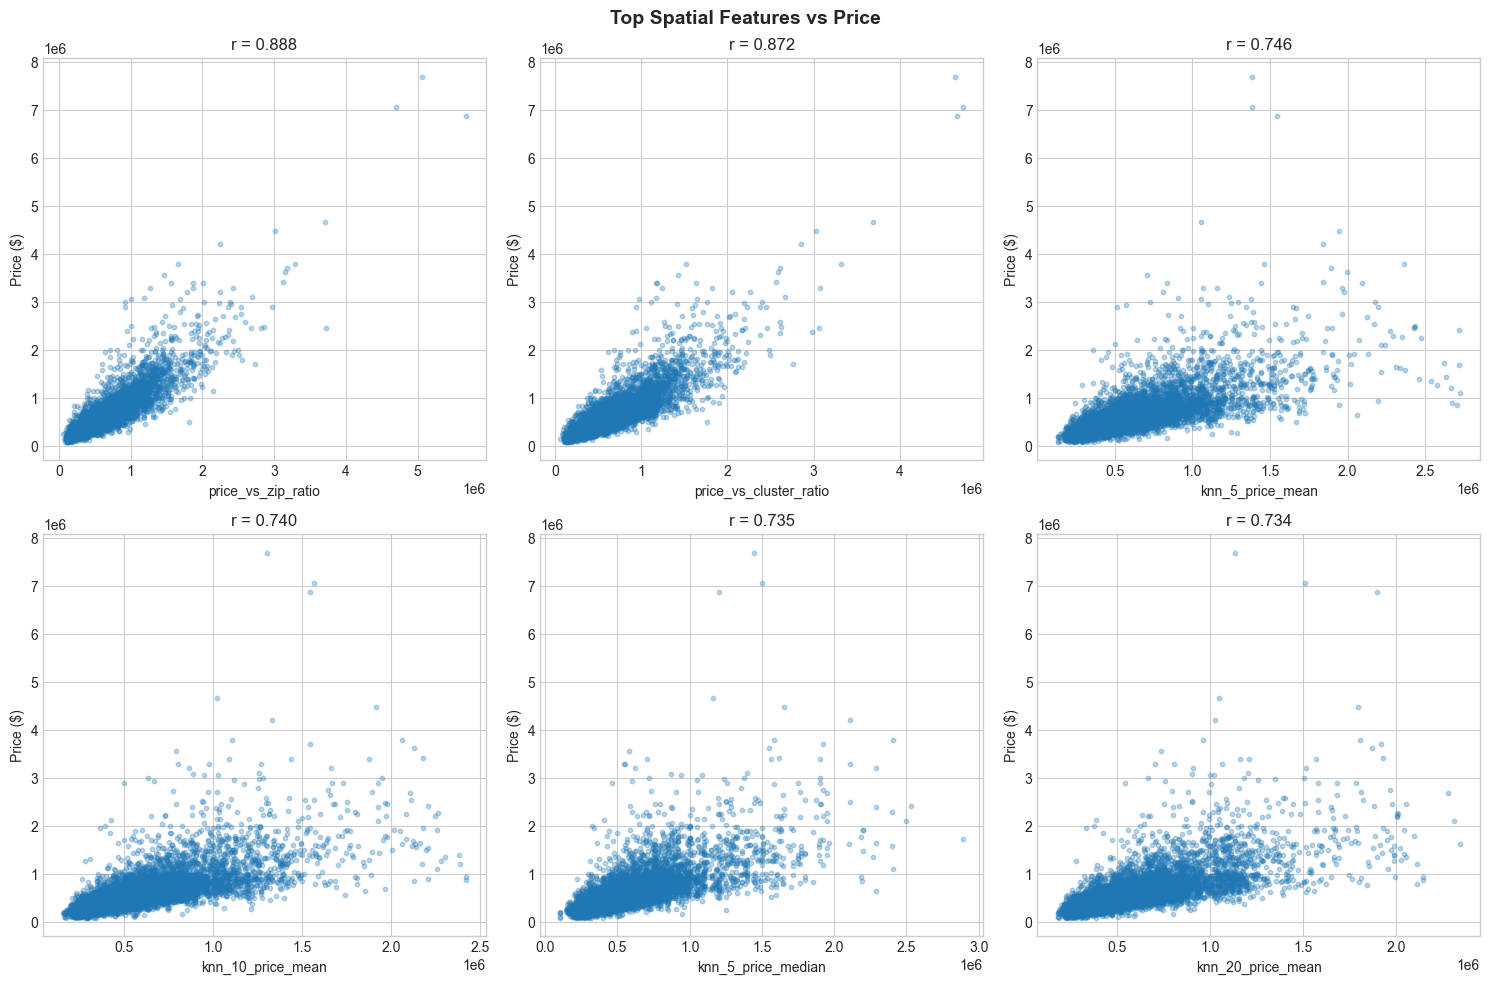


✓ Plot saved to outputs/spatial_eda/spatial_features_scatter.png


In [25]:
# Visualize top spatial features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

top_spatial_features = spatial_corr.head(6).index.tolist()

for idx, feat in enumerate(top_spatial_features):
    ax = axes[idx // 3, idx % 3]
    ax.scatter(
        train_spatial[feat], 
        train_df['price'], 
        alpha=0.3, 
        s=10
    )
    ax.set_xlabel(feat)
    ax.set_ylabel('Price ($)')
    ax.set_title(f'r = {spatial_corr[feat]:.3f}')

plt.suptitle('Top Spatial Features vs Price', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUTS_DIR}/spatial_features_scatter.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"\n✓ Plot saved to {OUTPUTS_DIR}/spatial_features_scatter.png")

In [26]:
train_df_full

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,image_path,knn_5_price_mean,knn_5_price_median,knn_5_price_std,...,dist_to_capitol_hill,dist_to_redmond_downtown,dist_to_nearest_downtown,dist_to_nearest_tech,dist_to_water,zip_price_mean,zip_price_median,zip_price_std,zip_count,zip_sqft_mean,zip_grade_mean,zip_lot_mean,price_vs_zip_ratio,sqft_vs_zip_ratio,grade_vs_zip_diff,cluster_price_mean,cluster_price_median,cluster_price_std,cluster_grade_mean,cluster_sqft_mean,price_vs_cluster_ratio,grade_vs_cluster_diff,lat_zone,long_zone,dist_from_center
0,7849201600,20140724T000000,286700,3,1.00,1220,6600,1.0,0,0,3,6,1220,0,1958,0,98065,47.5297,-121.827,1100,6600,/Users/vanshnarang/Desktop/cdc open project/da...,288580.0,320000.0,63537.277247,...,38.636627,27.294762,29.483827,26.545433,39.567766,539714.396739,508625.0,192254.799230,184,2602.445652,7.923913,19361.831522,2.529154e+05,0.468610,-1.923913,540342.629464,507125.0,195234.817280,7.843750,2574.866071,2.559209e+05,-1.843750,1.0,2.0,29.240603
1,5141000720,20140805T000000,400000,2,2.00,2010,3797,1.5,0,0,3,7,1450,560,1922,2004,98108,47.5596,-122.315,1660,4650,/Users/vanshnarang/Desktop/cdc open project/da...,373143.0,404000.0,45599.888114,...,7.325432,19.291847,5.338052,7.170917,5.584067,354603.126050,349950.0,101879.743626,119,1701.596639,7.025210,5294.915966,4.186266e+05,1.180550,-0.025210,445047.613995,386000.0,278187.025225,7.056433,1784.751693,5.009351e+05,-0.056433,1.0,0.0,7.589303
2,8651610580,20141107T000000,715000,4,2.50,2570,7980,2.0,0,0,3,9,2570,0,1998,0,98074,47.6378,-122.065,2760,6866,/Users/vanshnarang/Desktop/cdc open project/da...,778780.0,780000.0,61362.151201,...,19.323014,5.840436,10.683577,5.574194,21.051955,676801.207692,626400.0,280113.587419,260,2594.173077,8.626923,14392.953846,6.702363e+05,0.990300,0.373077,690555.862385,640000.0,271303.411571,8.645260,2685.107034,6.607066e+05,0.354740,2.0,1.0,14.078493
3,3935900005,20150501T000000,1039000,4,2.25,2740,11343,1.0,0,2,5,10,1980,760,1953,0,98125,47.7117,-122.278,2790,10027,/Users/vanshnarang/Desktop/cdc open project/da...,805590.0,775000.0,304688.287271,...,10.161368,12.440914,12.411079,10.830829,12.651944,466287.098814,425000.0,205622.643075,253,1705.059289,7.185771,7416.581028,7.488759e+05,1.606040,2.814229,434048.746082,387500.0,193231.785770,7.068966,1659.815047,7.160903e+05,2.931034,2.0,1.0,17.470580
4,1524079188,20140729T000000,1862000,4,5.25,5240,320917,2.0,0,2,3,10,5240,0,2006,0,98024,47.5605,-121.905,1930,68824,/Users/vanshnarang/Desktop/cdc open project/da...,445000.0,495000.0,97313.925006,...,32.104470,20.557593,22.911237,19.768886,33.171142,604065.500000,505000.0,360762.694811,50,2518.300000,7.580000,111049.640000,1.256422e+06,2.079943,2.420000,540342.629464,507125.0,195234.817280,7.843750,2574.866071,1.099201e+06,2.156250,1.0,2.0,23.176190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12962,3625059071,20150108T000000,899000,4,2.25,2290,40946,1.0,0,3,4,8,1550,740,1960,0,98008,47.6160,-122.103,2790,20076,/Users/vanshnarang/Desktop/cdc open project/da...,895500.0,790000.0,275523.864665,...,16.461418,6.596538,7.412678,3.983787,17.947911,633914.333333,539950.0,435239.226109,159,2105.283019,7.654088,10152.553459,6.892064e+05,1.087223,0.345912,663905.305842,556300.0,401717.829562,7.938144,2258.979381,6.727243e+05,0.061856,2.0,1.0,10.345275
12963,2538400040,20140524T000000,820000,4,2.50,3670,7000,2.0,0,0,3,10,3670,0,2005,0,98075,47.5854,-122.080,3680,7437,/Users/vanshnarang/Desktop/cdc open project/da...,665000.0,650000.0,121284.788824,...,18.692213,10.331050,9.515337,7.723760,19.784315,786228.238938,732000.0,286231.429816,226,3067.765487,9.030973,19895.960177,9.402666e+05,1.195921,0.969027,636585.545455,593350.0,275

In [27]:
columns_to_drop = ['id', 'date','price','image_path', 'zipcode']

X_train = train_df_full.drop(columns=columns_to_drop)
y_train = train_df_full['price']

X_val = val_df_full.drop(columns=columns_to_drop)
y_val = val_df_full['price']

print(X_train.shape)
print(X_val.shape)

(12967, 98)
(3242, 98)


In [28]:
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)

xgb_spatial = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb_spatial.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [29]:

y_pred = np.expm1(xgb_spatial.predict(X_val))
y_true = np.expm1(y_val)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"Baseline XGBoost RMSE: {rmse:,.0f}")
print(f"Baseline XGBoost R²  : {r2:.4f}")

Baseline XGBoost RMSE: 104,145
Baseline XGBoost R²  : 0.9136


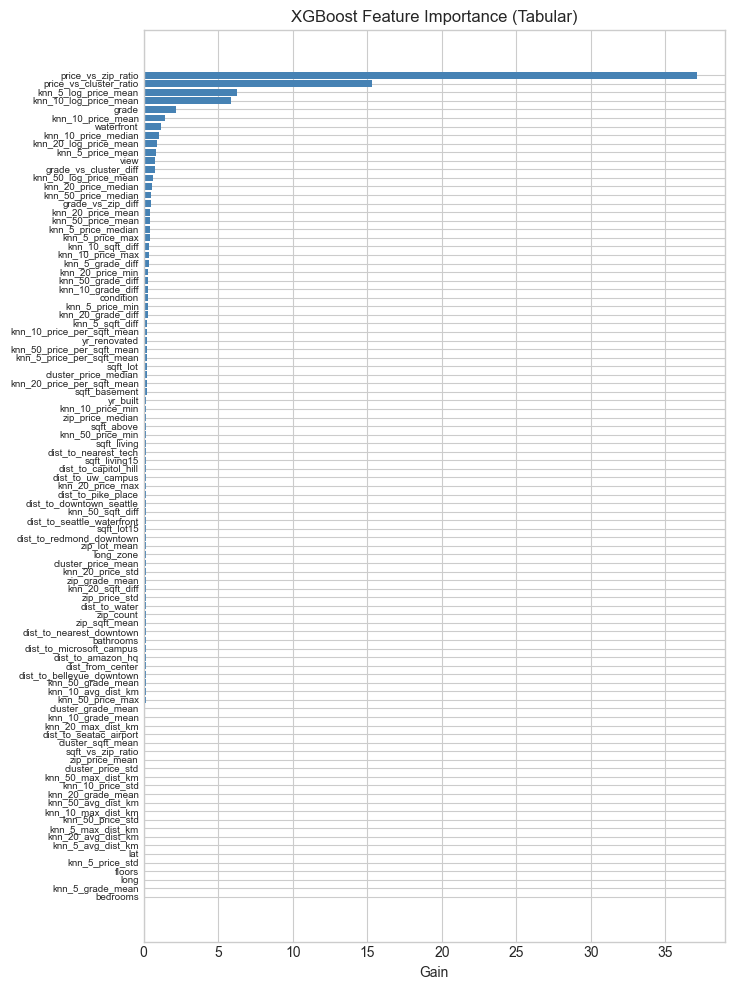

,feature,gain
85,price_vs_zip_ratio,37.138237
93,price_vs_cluster_ratio,15.282784
22,knn_5_log_price_mean,6.242000
34,knn_10_log_price_mean,5.836836
8,grade,2.191071
...,...,...
19,knn_5_price_std,0.083670
4,floors,0.077901
14,long,0.076857
27,knn_5_grade_mean,0.072369


In [30]:
importances = xgb_spatial.get_booster().get_score(importance_type="gain")

imp_df = (
    pd.DataFrame(importances.items(), columns=["feature", "gain"])
    .sort_values("gain", ascending=True)
)

plt.figure(figsize=(8, 10))
plt.barh(imp_df["feature"], imp_df["gain"], color="steelblue")
plt.title("XGBoost Feature Importance (Tabular)")
plt.xlabel("Gain")
plt.tight_layout()
plt.yticks(fontsize=7)
plt.show()

imp_df.sort_values("gain", ascending=False)

---
## 10. Define Feature Sets

In [31]:
current_year = 2015  # Using data's timeframe
train_df_full['age'] = current_year - train_df_full['yr_built']
train_df_full['years_since_renovation'] = np.where(
    train_df_full['yr_renovated'] > 0,
    current_year - train_df_full['yr_renovated'],
    train_df_full['age']
)

val_df_full['age'] = current_year - val_df_full['yr_built']
val_df_full['years_since_renovation'] = np.where(
    val_df_full['yr_renovated'] > 0,
    current_year - val_df_full['yr_renovated'],
    val_df_full['age']
)

In [32]:
train_df_full['sqft_per_bedroom'] = train_df_full['sqft_living'] / (train_df_full['bedrooms'] + 1)
train_df_full['sqft_per_bathroom'] = train_df_full['sqft_living'] / (train_df_full['bathrooms'] + 0.5)
train_df_full['sqft_per_room'] = train_df_full['sqft_living'] / (train_df_full['bedrooms'] + train_df_full['bathrooms'] + 1)

val_df_full['sqft_per_bedroom'] = val_df_full['sqft_living'] / (val_df_full['bedrooms'] + 1)
val_df_full['sqft_per_bathroom'] = val_df_full['sqft_living'] / (val_df_full['bathrooms'] + 0.5)
val_df_full['sqft_per_room'] = val_df_full['sqft_living'] / (val_df_full['bedrooms'] + val_df_full['bathrooms'] + 1)

In [33]:
train_df_full['quality_score'] = train_df_full['grade'] + train_df_full['condition']
train_df_full['luxury_index'] = (train_df_full['grade'] >= 10).astype(int) + \
                     (train_df_full['sqft_living'] >= 4000).astype(int) + \
                     train_df_full['waterfront'] + \
                     (train_df_full['view'] >= 3).astype(int)

val_df_full['quality_score'] = val_df_full['grade'] + val_df_full['condition']
val_df_full['luxury_index'] = (val_df_full['grade'] >= 10).astype(int) + \
                     (val_df_full['sqft_living'] >= 4000).astype(int) + \
                     val_df_full['waterfront'] + \
                     (val_df_full['view'] >= 3).astype(int)

print("Quality features created")

Quality features created


In [34]:
print("Train: ", train_df_full.shape)
print("Val:   ", val_df_full.shape)

Train:  (12967, 110)
Val:    (3242, 110)


In [35]:
# Base tabular features (original + engineered)
BASE_TABULAR_FEATURES = [
    # Original features
    'bedrooms', 'bathrooms', 'sqft_living',
    'waterfront', 'view', 'grade', 'sqft_above',
    'sqft_living15', 'sqft_lot15',
    # Engineered features
    'age', 'years_since_renovation', 'sqft_per_bedroom', 'sqft_per_bathroom',
    'sqft_per_room', 'quality_score', 'luxury_index',

    ]
# Filter to only include features that exist
BASE_TABULAR_FEATURES = [f for f in BASE_TABULAR_FEATURES if f in train_df_full.columns]

# Top spatial features (based on correlation)
TOP_SPATIAL_FEATURES = spatial_corr.head(30).index.tolist()

# All spatial features
ALL_SPATIAL_FEATURES = spatial_cols

# Feature set combinations
FEATURE_SETS = {
    'base_only': BASE_TABULAR_FEATURES,
    'base_plus_top_spatial': BASE_TABULAR_FEATURES + TOP_SPATIAL_FEATURES ,
    'base_plus_all_spatial': BASE_TABULAR_FEATURES + ALL_SPATIAL_FEATURES,
    'spatial_only': ALL_SPATIAL_FEATURES,
}

print("FEATURE SETS DEFINED")
print("="*60)
for name, features in FEATURE_SETS.items():
    print(f"  • {name}: {len(features)} features")

FEATURE SETS DEFINED
  • base_only: 16 features
  • base_plus_top_spatial: 46 features
  • base_plus_all_spatial: 97 features
  • spatial_only: 81 features


In [36]:
# Default feature set for training
SELECTED_FEATURES = FEATURE_SETS['base_plus_top_spatial']

print(f"\nSELECTED FEATURE SET: base_plus_top_spatial")
print(f"Total features: {len(SELECTED_FEATURES)}")
print(f"\nFeatures:")
for i, f in enumerate(SELECTED_FEATURES):
    print(f"  {i+1:2d}. {f}")


SELECTED FEATURE SET: base_plus_top_spatial
Total features: 46

Features:
   1. bedrooms
   2. bathrooms
   3. sqft_living
   4. waterfront
   5. view
   6. grade
   7. sqft_above
   8. sqft_living15
   9. sqft_lot15
  10. age
  11. years_since_renovation
  12. sqft_per_bedroom
  13. sqft_per_bathroom
  14. sqft_per_room
  15. quality_score
  16. luxury_index
  17. price_vs_zip_ratio
  18. price_vs_cluster_ratio
  19. knn_5_price_mean
  20. knn_10_price_mean
  21. knn_5_price_median
  22. knn_20_price_mean
  23. knn_10_price_median
  24. knn_20_price_median
  25. knn_50_price_mean
  26. knn_5_log_price_mean
  27. knn_10_log_price_mean
  28. knn_50_price_median
  29. knn_20_log_price_mean
  30. knn_5_price_min
  31. knn_50_log_price_mean
  32. knn_5_price_max
  33. knn_10_price_min
  34. knn_10_price_max
  35. knn_20_price_min
  36. zip_price_mean
  37. zip_price_median
  38. knn_20_price_max
  39. knn_50_price_std
  40. knn_50_price_min
  41. knn_20_price_std
  42. cluster_price_mean


---
## 11. Target Transformation

TARGET TRANSFORMATION
Original price skewness: 4.22
Log price skewness:      0.41


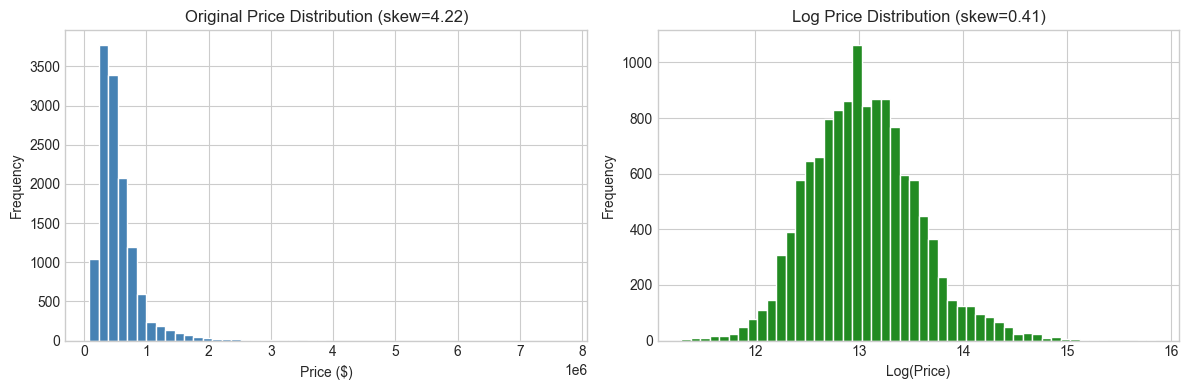

In [37]:
print("="*60)
print("TARGET TRANSFORMATION")
print("="*60)

# Log transform price (reduces skewness)
train_df_full['log_price'] = np.log1p(train_df_full['price'])
val_df_full['log_price'] = np.log1p(val_df_full['price'])

print(f"Original price skewness: {train_df_full['price'].skew():.2f}")
print(f"Log price skewness:      {train_df_full['log_price'].skew():.2f}")

# Visualize transformation
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(train_df_full['price'], bins=50, color='steelblue', edgecolor='white')
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Original Price Distribution (skew={train_df_full["price"].skew():.2f})')

axes[1].hist(train_df_full['log_price'], bins=50, color='forestgreen', edgecolor='white')
axes[1].set_xlabel('Log(Price)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Log Price Distribution (skew={train_df_full["log_price"].skew():.2f})')

plt.tight_layout()
plt.savefig(f"{OUTPUTS_DIR}/price_transformation.png", dpi=150, bbox_inches='tight')
plt.show()

---
## 12. Feature Scaling

In [38]:
train_df_final = train_df_full[SELECTED_FEATURES].copy()
val_df_final = val_df_full[SELECTED_FEATURES].copy()

In [39]:
train_df_final

,bedrooms,bathrooms,sqft_living,waterfront,view,grade,sqft_above,sqft_living15,sqft_lot15,age,years_since_renovation,sqft_per_bedroom,sqft_per_bathroom,sqft_per_room,quality_score,luxury_index,price_vs_zip_ratio,price_vs_cluster_ratio,knn_5_price_mean,knn_10_price_mean,knn_5_price_median,knn_20_price_mean,knn_10_price_median,knn_20_price_median,knn_50_price_mean,knn_5_log_price_mean,knn_10_log_price_mean,knn_50_price_median,knn_20_log_price_mean,knn_5_price_min,knn_50_log_price_mean,knn_5_price_max,knn_10_price_min,knn_10_price_max,knn_20_price_min,zip_price_mean,zip_price_median,knn_20_price_max,knn_50_price_std,knn_50_price_min,knn_20_price_std,cluster_price_mean,knn_50_price_max,cluster_price_median,zip_price_std,knn_10_price_std
0,3,1.00,1220,0,0,6,1220,1100,6600,57,57,305.0,813.333333,244.000000,9,0,2.529154e+05,2.559209e+05,288580.0,328309.0,320000.0,360629.90,329000.0,338450.0,497398.46,12.542410,12.672349,438859.0,12.766343,170000,13.044015,339900,170000,450000,170000,539714.396739,508625.0,532500,202061.517750,170000,82140.804317,540342.629464,1210000,507125.0,192254.799230,74038.902808
1,2,2.00,2010,0,0,7,1450,1660,4650,93,11,670.0,804.000000,402.000000,10,0,4.186266e+05,5.009351e+05,373143.0,370571.5,404000.0,407435.75,399500.0,413357.5,393803.30,12.821942,12.807496,397500.0,12.896520,315000,12.862325,415000,235000,430000,235000,354603.126050,349950.0,605000,79783.900529,235000,82956.143131,445047.613995,605000,386000.0,101879.743626,60118.944687
2,4,2.50,2570,0,0,9,2570,2760,6866,17,17,514.0,856.666667,342.666667,12,0,6.702363e+05,6.607066e+05,778780.0,789810.0,780000.0,873315.00,807750.0,805000.0,704273.36,13.562232,13.572660,640350.0,13.624394,670000,13.404184,839900,600000,920000,600000,676801.207692,626400.0,2400000,299827.560897,310000,376422.442576,690555.862385,2400000,640000.0,280113.587419,89145.717227
3,4,2.25,2740,0,2,10,1980,2790,10027,62,62,548.0,996.363636,377.931034,15,1,7.488759e+05,7.160903e+05,805590.0,592195.0,775000.0,611632.50,525000.0,566500.0,580099.00,13.531441,13.149959,520000.0,13.222176,429950,13.169715,1360000,207000,1360000,207000,466287.098814,425000.0,1360000,305143.440449,207000,281730.047330,434048.746082,2000000,387500.0,205622.643075,319502.710826
4,4,5.25,5240,0,2,10,5240,1930,68824,9,9,1048.0,911.304348,511.219512,13,2,1.256422e+06,1.099201e+06,445000.0,418700.0,495000.0,424835.00,432500.0,407500.0,513861.00,12.977464,12.897350,499000.0,12.894057,275000,13.099715,540000,213000,600000,205000,604065.500000,505000.0,810000,153003.829132,205000,151893.703869,540342.629464,835000,507125.0,360762.694811,120458.333045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12962,4,2.25,2290,0,3,8,1550,2790,20076,55,55,458.0,832.727273,315.862069,12,1,6.892064e+05,6.727243e+05,895500.0,765565.0,790000.0,681357.50,643825.0,592500.0,700900.48,13.660219,13.474961,555650.0,13.379429,600000,13.314069,1355000,427000,1355000,427000,633914.333333,539950.0,1355000,565630.431214,268500,243939.179548,663905.305842,3300000,556300.0,435239.226109,302199.004011
12963,4,2.50,3670,0,0,10,3670,3680,7437,10,10,734.0,1223.333333,489.333333,13,1,9.402666e+05,9.692681e+05,665000.0,649370.0,650000.0,917895.50,619350.0,677500.0,854225.92,13.391776,13.370290,800000.0,13.592126,545000,13.583647,875000,545000,875000,450000,786228.238938,732000.0,3200000,426999.560692,450000,620861.181976,636585.545455,3200000,593350.0,286231.429816,110686.819902
12964,3,1.00,1130,0,0,7,1130,2280,8750,61,61,282.5,753.333333,226.000000,10,0,2.789600e+05,2.816202e+05,604240.0,595525.0,598200.0,577911.35,599075.0,520100.0,522663.62,13.294909,13.270973,476000.0,13.202856,475000,13.094197,810000,389100,850000,315000,416396.216393,366350.0,1442500,213415.026305,167500,240699.641156,445047.613995,1442500,386000.0,241086.745472,137841.864559
12965,3,2.25,1280,0,0,8,1080,1280,1681,7,7,320.0,465.454545,204.800

In [40]:
CATEGORICAL_FEATURES = ['waterfront', 'view']

In [41]:
print("="*60)
print("FEATURE SCALING (NUMERIC ONLY)")
print("="*60)

from sklearn.preprocessing import StandardScaler

NUMERIC_FEATURES = [
    f for f in SELECTED_FEATURES
    if f not in CATEGORICAL_FEATURES
]

print(f"Numeric features (scaled): {NUMERIC_FEATURES}")
print(f"Categorical features (unscaled): {CATEGORICAL_FEATURES}")


X_train_num = train_df_full[NUMERIC_FEATURES].copy()
X_val_num   = val_df_full[NUMERIC_FEATURES].copy()

X_train_cat = train_df_full[CATEGORICAL_FEATURES].copy()
X_val_cat   = val_df_full[CATEGORICAL_FEATURES].copy()

# Handle missing values
X_train_num = X_train_num.fillna(X_train_num.median())
X_val_num   = X_val_num.fillna(X_train_num.median())

X_train_cat = X_train_cat.fillna(X_train_cat.mode().iloc[0])
X_val_cat   = X_val_cat.fillna(X_train_cat.mode().iloc[0])


#Scaling only numeric features
scaler = StandardScaler()

X_train_num_scaled = scaler.fit_transform(X_train_num)
X_val_num_scaled   = scaler.transform(X_val_num)

X_train_num_scaled = pd.DataFrame(
    X_train_num_scaled,
    columns=NUMERIC_FEATURES,
    index=X_train_num.index
)

X_val_num_scaled = pd.DataFrame(
    X_val_num_scaled,
    columns=NUMERIC_FEATURES,
    index=X_val_num.index
)

X_train_scaled = pd.concat(
    [X_train_num_scaled, X_train_cat],
    axis=1
)[SELECTED_FEATURES]   # preserve original order

X_val_scaled = pd.concat(
    [X_val_num_scaled, X_val_cat],
    axis=1
)[SELECTED_FEATURES]

y_train = train_df_full["log_price"].values
y_val   = val_df_full["log_price"].values

y_train_original = train_df_full["price"].values
y_val_original   = val_df_full["price"].values


print(f"X_train shape: {X_train_scaled.shape}")
print(f"X_val shape:   {X_val_scaled.shape}")
print("\nNumeric features scaled, categorical features left unscaled")


FEATURE SCALING (NUMERIC ONLY)
Numeric features (scaled): ['bedrooms', 'bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'age', 'years_since_renovation', 'sqft_per_bedroom', 'sqft_per_bathroom', 'sqft_per_room', 'quality_score', 'luxury_index', 'price_vs_zip_ratio', 'price_vs_cluster_ratio', 'knn_5_price_mean', 'knn_10_price_mean', 'knn_5_price_median', 'knn_20_price_mean', 'knn_10_price_median', 'knn_20_price_median', 'knn_50_price_mean', 'knn_5_log_price_mean', 'knn_10_log_price_mean', 'knn_50_price_median', 'knn_20_log_price_mean', 'knn_5_price_min', 'knn_50_log_price_mean', 'knn_5_price_max', 'knn_10_price_min', 'knn_10_price_max', 'knn_20_price_min', 'zip_price_mean', 'zip_price_median', 'knn_20_price_max', 'knn_50_price_std', 'knn_50_price_min', 'knn_20_price_std', 'cluster_price_mean', 'knn_50_price_max', 'cluster_price_median', 'zip_price_std', 'knn_10_price_std']
Categorical features (unscaled): ['waterfront', 'view']
X_train shape: (12967, 46)


---
## 14. Save Processed Data

In [42]:
print(len(SELECTED_FEATURES))

46


In [43]:
print("="*60)
print("SAVING PROCESSED DATA")
print("="*60)

# Columns to save
save_columns = SELECTED_FEATURES + ['price', 'image_path']

# Remove duplicates and filter to existing columns
save_columns = list(dict.fromkeys([c for c in save_columns if c in train_df_full.columns]))

# Save CSV files
train_df_full[save_columns].to_csv(f"{OUTPUT_DIR}/train.csv", index=False)
val_df_full[save_columns].to_csv(f"{OUTPUT_DIR}/val.csv", index=False)

print(f"train.csv saved: {len(train_df_full)} samples")
print(f"val.csv saved:   {len(val_df_full)} samples")

SAVING PROCESSED DATA
train.csv saved: 12967 samples
val.csv saved:   3242 samples


## 15. Save Testing Data


In [45]:
TEST_DATA_PATH = "../data/test_images_19/data_with_image_paths.csv"  
SPATIAL_TRANSFORMER_PATH = "outputs/spatial_eda/spatial_feature_transformer.pkl"  # Path to saved transformer
OUTPUT_PATH = "../data/processed/test.csv"

# Constants
RANDOM_STATE = 42
CURRENT_YEAR = 2015

# Categorical features
CATEGORICAL_FEATURES = ['waterfront', 'view']

In [46]:
print("="*60)
print("LOADING TEST DATA")
print("="*60)

test_df = pd.read_csv(TEST_DATA_PATH)
print(f"Test data shape: {test_df.shape}")
print(f"Columns: {list(test_df.columns)}")

LOADING TEST DATA
Test data shape: (5404, 21)
Columns: ['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'image_path']


In [47]:
test_df

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,image_path
0,2591820310,20141006T000000,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,/Users/vanshnarang/Desktop/cdc open project/tr...
1,7974200820,20140821T000000,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,/Users/vanshnarang/Desktop/cdc open project/tr...
2,7701450110,20140815T000000,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,/Users/vanshnarang/Desktop/cdc open project/tr...
3,9522300010,20150331T000000,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,/Users/vanshnarang/Desktop/cdc open project/tr...
4,9510861140,20140714T000000,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,/Users/vanshnarang/Desktop/cdc open project/tr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5399,7732500270,20140925T000000,4,2.50,2820,15000,2.0,0,0,4,9,2820,0,1985,0,98052,47.7255,-122.101,2440,15000,/Users/vanshnarang/Desktop/cdc open project/tr...
5400,3856903515,20141222T000000,3,2.00,1460,6250,1.5,0,0,4,7,1460,0,1912,0,98103,47.6693,-122.333,1690,4750,/Users/vanshnarang/Desktop/cdc open project/tr...
5401,2557000400,20150409T000000,3,2.50,2070,9900,1.0,0,0,3,8,1420,650,1979,0,98023,47.2988,-122.371,2070,8250,/Users/vanshnarang/Desktop/cdc open project/tr...
5402,4386700135,20141114T000000,4,2.25,4760,8036,2.5,0,0,5,9,3390,1370,1916,0,98112,47.6415,-122.285,2950,9323,/Users/vanshnarang/Desktop/cdc open project/tr...


In [50]:
test_df['image_path'] = test_df['image_path'].str.replace(
    '/Users/vanshnarang/Desktop/cdc open project/',
    '/Users/vanshnarang/Desktop/cdc open project/data/',
    regex=False
)


In [63]:
test_df['image_path'] = test_df['image_path'].str.replace(
    '/Users/vanshnarang/Desktop/cdc open project/data/train',
    '/Users/vanshnarang/Desktop/cdc open project/data/test',
    regex=False
)

In [65]:
test_df

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,image_path,sale_year,sale_month,age,years_since_renovation,has_basement,has_view,was_renovated,living_lot_ratio,above_basement_ratio,sqft_per_bedroom,sqft_per_bathroom,total_rooms,sqft_per_room,quality_score,luxury_index,sqft_living_vs_neighbors,sqft_lot_vs_neighbors
0,2591820310,2014-10-06,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,/Users/vanshnarang/Desktop/cdc open project/da...,2014,10,29,29,0,0,0,0.232741,0.999517,414.000000,752.727273,6.25,285.517241,12,0,-320,1193
1,7974200820,2014-08-21,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,/Users/vanshnarang/Desktop/cdc open project/da...,2014,8,38,38,1,0,0,0.430842,0.630817,483.333333,828.571429,8.00,322.222222,13,0,530,447
2,7701450110,2014-08-15,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,/Users/vanshnarang/Desktop/cdc open project/da...,2014,8,18,18,0,1,0,0.346062,0.999735,754.000000,1256.666667,6.50,502.666667,14,1,60,1208
3,9522300010,2015-03-31,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,/Users/vanshnarang/Desktop/cdc open project/da...,2015,3,25,25,0,1,0,0.312136,0.999781,1140.000000,1140.000000,6.50,608.000000,15,2,510,382
4,9510861140,2014-07-14,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,/Users/vanshnarang/Desktop/cdc open project/da...,2014,7,11,11,0,0,0,0.474242,0.999608,637.500000,850.000000,5.50,392.307692,12,0,300,1326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5399,7732500270,2014-09-25,4,2.50,2820,15000,2.0,0,0,4,9,2820,0,1985,0,98052,47.7255,-122.101,2440,15000,/Users/vanshnarang/Desktop/cdc open project/da...,2014,9,30,30,0,0,0,0.187987,0.999646,564.000000,940.000000,6.50,376.000000,13,0,380,0
5400,3856903515,2014-12-22,3,2.00,1460,6250,1.5,0,0,4,7,1460,0,1912,0,98103,47.6693,-122.333,1690,4750,/Users/vanshnarang/Desktop/cdc open project/da...,2014,12,103,103,0,0,0,0.233563,0.999316,365.000000,584.000000,5.00,243.333333,11,0,-230,1500
5401,2557000400,2015-04-09,3,2.50,2070,9900,1.0,0,0,3,8,1420,650,1979,0,98023,47.2988,-122.371,2070,8250,/Users/vanshnarang/Desktop/cdc open project/da...,2015,4,36,36,1,0,0,0.209070,0.685659,517.500000,690.000000,5.50,318.461538,11,0,0,1650
5402,4386700135,2014-11-14,4,2.25,4760,8036,2.5,0,0,5,9,3390,1370,1916,0,98112,47.6415,-122.285,2950,9323,/Users/vanshnarang/Desktop/cdc open project/da...,2014,11,99,99,1,0,0,0.592261,0.712035,952.000000,1730.909091,6.25,656.551724,14,1,1810,-1287


In [66]:
print("\n" + "="*60)
print("FEATURE ENGINEERING")
print("="*60)

# 1. Date features (if date column exists)
if 'date' in test_df.columns:
    test_df['date'] = pd.to_datetime(test_df['date'])
    test_df['sale_year'] = test_df['date'].dt.year
    test_df['sale_month'] = test_df['date'].dt.month
    print("✓ Date features extracted")

# 2. Age features
test_df['age'] = CURRENT_YEAR - test_df['yr_built']
test_df['years_since_renovation'] = np.where(
    test_df['yr_renovated'] > 0,
    CURRENT_YEAR - test_df['yr_renovated'],
    test_df['age']
)
print("✓ Age features created")

# 3. Binary features
test_df['has_basement'] = (test_df['sqft_basement'] > 0).astype(int)
test_df['has_view'] = (test_df['view'] > 0).astype(int)
test_df['was_renovated'] = (test_df['yr_renovated'] > 0).astype(int)
print("✓ Binary features created")

# 4. Ratio features
test_df['living_lot_ratio'] = test_df['sqft_living'] / (test_df['sqft_lot'] + 1)
test_df['above_basement_ratio'] = test_df['sqft_above'] / (test_df['sqft_living'] + 1)
test_df['sqft_per_bedroom'] = test_df['sqft_living'] / (test_df['bedrooms'] + 1)
test_df['sqft_per_bathroom'] = test_df['sqft_living'] / (test_df['bathrooms'] + 0.5)
test_df['total_rooms'] = test_df['bedrooms'] + test_df['bathrooms']
test_df['sqft_per_room'] = test_df['sqft_living'] / (test_df['total_rooms'] + 1)
print("✓ Ratio features created")

# 5. Quality features
test_df['quality_score'] = test_df['grade'] + test_df['condition']
test_df['luxury_index'] = (test_df['grade'] >= 10).astype(int) + \
                          (test_df['sqft_living'] >= 4000).astype(int) + \
                          test_df['waterfront'] + \
                          (test_df['view'] >= 3).astype(int)
print("✓ Quality features created")

# 6. Neighbor comparison features (if available)
if 'sqft_living15' in test_df.columns:
    test_df['sqft_living_vs_neighbors'] = test_df['sqft_living'] - test_df['sqft_living15']
    test_df['sqft_lot_vs_neighbors'] = test_df['sqft_lot'] - test_df['sqft_lot15']
    print("✓ Neighbor comparison features created")

print(f"\nTotal features after engineering: {len(test_df.columns)}")


FEATURE ENGINEERING
✓ Date features extracted
✓ Age features created
✓ Binary features created
✓ Ratio features created
✓ Quality features created
✓ Neighbor comparison features created

Total features after engineering: 38


In [67]:
print("\n" + "="*60)
print("APPLYING SPATIAL FEATURES")
print("="*60)

try:
    # Load the fitted spatial transformer
    with open(SPATIAL_TRANSFORMER_PATH, 'rb') as f:
        spatial_transformer = pickle.load(f)
    print(f"✓ Spatial transformer loaded from {SPATIAL_TRANSFORMER_PATH}")
    
    # Transform test data (is_training=False, important!)
    test_spatial = spatial_transformer.transform(test_df, is_training=False)
    print(f"✓ Spatial features generated: {test_spatial.shape[1]} features")
    
    # Merge spatial features
    test_df_full = pd.concat([
        test_df.reset_index(drop=True), 
        test_spatial.reset_index(drop=True)
    ], axis=1)
    print(f"✓ Combined shape: {test_df_full.shape}")
    
except FileNotFoundError:
    print(f"⚠ WARNING: Spatial transformer not found at {SPATIAL_TRANSFORMER_PATH}")
    print("⚠ Proceeding without spatial features. You need to run the training notebook first")
    print("⚠ and save the spatial_transformer using: spatial_transformer.save('path/to/save.pkl')")
    test_df_full = test_df.copy()


APPLYING SPATIAL FEATURES
✓ Spatial transformer loaded from outputs/spatial_eda/spatial_feature_transformer.pkl
Transforming 5404 samples (is_training=False)...
KNN features computed for k=[5, 10, 20, 50]
Distance features computed for 10 locations
Zipcode features computed
Cluster features computed
Geographic zone features computed
Total spatial features: 81
✓ Spatial features generated: 81 features
✓ Combined shape: (5404, 119)


In [73]:
# Define the same feature sets as training
BASE_TABULAR_FEATURES = [
    'bedrooms', 'bathrooms', 'sqft_living',
    'waterfront', 'view', 'grade', 'sqft_above',
    'sqft_living15', 'sqft_lot15',
    'age', 'years_since_renovation', 'sqft_per_bedroom', 
    'sqft_per_bathroom', 'sqft_per_room', 'quality_score', 'luxury_index',
]

# Filter to only features that exist
BASE_TABULAR_FEATURES = [f for f in BASE_TABULAR_FEATURES if f in test_df_full.columns]

TOP_SPATIAL_FEATURES = spatial_corr.head(30).index.tolist()
    
SELECTED_FEATURES = BASE_TABULAR_FEATURES + TOP_SPATIAL_FEATURES
print(f"✓ Using base + top 30 spatial features")



✓ Using base + top 30 spatial features


In [74]:
print("\n" + "="*60)
print("PREPARING FINAL DATASET")
print("="*60)

# Columns to save (features + image_path, NO price)
save_columns = SELECTED_FEATURES + ['image_path'] + ['id']

# Remove duplicates and filter to existing columns
save_columns = list(dict.fromkeys([c for c in save_columns if c in test_df_full.columns]))

# Create final test dataframe
test_df_final = test_df_full[save_columns].copy()

print(f"Final test shape: {test_df_final.shape}")
print(f"Columns: {len(save_columns)}")


PREPARING FINAL DATASET
Final test shape: (5404, 48)
Columns: 48


In [75]:
test_df_final

,bedrooms,bathrooms,sqft_living,waterfront,view,grade,sqft_above,sqft_living15,sqft_lot15,age,years_since_renovation,sqft_per_bedroom,sqft_per_bathroom,sqft_per_room,quality_score,luxury_index,price_vs_zip_ratio,price_vs_cluster_ratio,knn_5_price_mean,knn_10_price_mean,knn_5_price_median,knn_20_price_mean,knn_10_price_median,knn_20_price_median,knn_50_price_mean,knn_5_log_price_mean,knn_10_log_price_mean,knn_50_price_median,knn_20_log_price_mean,knn_5_price_min,knn_50_log_price_mean,knn_5_price_max,knn_10_price_min,knn_10_price_max,knn_20_price_min,zip_price_mean,zip_price_median,knn_20_price_max,knn_50_price_std,knn_50_price_min,knn_20_price_std,cluster_price_mean,knn_50_price_max,cluster_price_median,zip_price_std,knn_10_price_std,image_path,id
0,4,2.25,2070,0,0,8,2070,2390,7700,29,29,414.000000,752.727273,285.517241,12,0,3.563384e+05,3.487975e+05,404000.0,390090.0,397500.0,360637.55,388000.0,361500.0,340341.02,12.906991,12.868531,329000.0,12.780702,365000,12.718993,435000,315000,460000,272000,3.513304e+05,336500.0,469900,63312.121710,151600,62208.240250,308031.324503,469900,300000.0,121267.127316,41060.235021,/Users/vanshnarang/Desktop/cdc open project/da...,2591820310
1,5,3.00,2900,0,0,8,1830,2370,6283,38,38,483.333333,828.571429,322.222222,13,0,9.888585e+05,1.047218e+06,629600.0,593700.0,637000.0,624600.35,605000.0,620250.0,665554.20,13.336933,13.273196,625000.0,13.309977,439000,13.363673,750000,415000,775000,415000,6.162745e+05,557500.0,953007,217330.773816,415000,167550.275686,721473.037855,1535000,625000.0,237053.466555,119351.623366,/Users/vanshnarang/Desktop/cdc open project/da...,7974200820
2,4,2.50,3770,0,2,11,3770,3710,9685,18,18,754.000000,1256.666667,502.666667,14,1,1.138205e+06,1.116942e+06,906000.0,786560.0,963000.0,756440.00,664250.0,670750.0,698682.00,13.679018,13.541818,664250.0,13.511755,605000,13.419596,1164000,590000,1164000,582000,8.696867e+05,756000.0,1164000,193730.627099,365000,177011.218289,848921.282958,1200000,760000.0,465696.094487,214016.430210,/Users/vanshnarang/Desktop/cdc open project/da...,7701450110
3,3,3.50,4560,0,2,12,4560,4050,14226,25,25,1140.000000,1140.000000,608.000000,15,2,1.172087e+06,1.123977e+06,1051701.0,1137921.1,853505.0,1152495.55,778808.0,881752.5,869531.22,13.712804,13.757088,665000.0,13.787844,435000,13.507609,1950000,435000,3070000,435000,5.135766e+05,440500.0,3395000,614617.294894,342500,787484.922839,512672.704225,3395000,450000.0,265162.606231,780648.612765,/Users/vanshnarang/Desktop/cdc open project/da...,9522300010
4,3,2.50,2550,0,0,9,2550,2250,4050,11,11,637.500000,850.000000,392.307692,12,0,6.929010e+05,6.784184e+05,771920.0,772725.0,789500.0,795262.50,693500.0,693500.0,730974.86,13.549760,13.529825,667500.0,13.538542,674000,13.412618,918000,540000,1295650,500000,6.539797e+05,624000.0,1769000,336620.847749,259875,283993.037272,685628.029703,1800000,695000.0,203515.249495,199629.287994,/Users/vanshnarang/Desktop/cdc open project/da...,9510861140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5399,4,2.50,2820,0,0,9,2820,2440,15000,30,30,564.000000,940.000000,376.000000,13,0,7.662670e+05,6.724486e+05,617300.0,600537.1,637000.0,693603.55,607000.0,626000.0,742471.42,13.328466,13.301940,685000.0,13.419583,515000,13.471829,690000,515000,690000,479000,6.539797e+05,624000.0,1157200,228660.245941,299000,180886.005275,598988.981250,1350000,575275.0,203515.249495,50988.679898,/Users/vanshnarang/Desktop/cdc open project/da...,7732500270
5400,3,2.00,1460,0,0,7,1460,1690,4750,103,103,365.000000,584.000000,243.333333,11,0,5.117116e+05,4.915049e+05,921440.0,767370.0,875000.0,724407.50,739500.0,699500.0,704438.00,13.712897,13.516184,676375.0,13.464616,759000,13.428939,1311000,495000,1311000,470450,5.715676e+05,543000.0,1311000,195203.281878,417000,185061.107661,572762.021390,1311000,531085.0,199039.263257,215920.337393,/Users/vanshnaran

In [76]:
print("\n" + "="*60)
print("SAVING TEST DATASET")
print("="*60)

test_df_final.to_csv(OUTPUT_PATH, index=False)
print(f"✓ Test dataset saved to: {OUTPUT_PATH}")
print(f"  - Samples: {len(test_df_final)}")
print(f"  - Features: {len(test_df_final.columns) - 1}")  # -1 for image_path
print(f"  - Columns: {list(test_df_final.columns[:10])}... (showing first 10)")

print("\n" + "="*60)
print("PREPROCESSING COMPLETE!")
print("="*60)


SAVING TEST DATASET
✓ Test dataset saved to: ../data/processed/test.csv
  - Samples: 5404
  - Features: 47
  - Columns: ['bedrooms', 'bathrooms', 'sqft_living', 'waterfront', 'view', 'grade', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'age']... (showing first 10)

PREPROCESSING COMPLETE!


In [77]:
print(SELECTED_FEATURES)

['bedrooms', 'bathrooms', 'sqft_living', 'waterfront', 'view', 'grade', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'age', 'years_since_renovation', 'sqft_per_bedroom', 'sqft_per_bathroom', 'sqft_per_room', 'quality_score', 'luxury_index', 'price_vs_zip_ratio', 'price_vs_cluster_ratio', 'knn_5_price_mean', 'knn_10_price_mean', 'knn_5_price_median', 'knn_20_price_mean', 'knn_10_price_median', 'knn_20_price_median', 'knn_50_price_mean', 'knn_5_log_price_mean', 'knn_10_log_price_mean', 'knn_50_price_median', 'knn_20_log_price_mean', 'knn_5_price_min', 'knn_50_log_price_mean', 'knn_5_price_max', 'knn_10_price_min', 'knn_10_price_max', 'knn_20_price_min', 'zip_price_mean', 'zip_price_median', 'knn_20_price_max', 'knn_50_price_std', 'knn_50_price_min', 'knn_20_price_std', 'cluster_price_mean', 'knn_50_price_max', 'cluster_price_median', 'zip_price_std', 'knn_10_price_std']
